In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# LSTM Model - Target prediction based on lagged target values only
<b>Key points: -</b><br>
1) The sequence will consist only of the target values and stock IDs in the previous K time IDs.<br>
2) The above sequence will be used to make the prediction for the next time ID.<br>
3) The model will simulate auto-regression by using the target prediction for time ID K in making the prediction for time ID (K + 1).<br> 

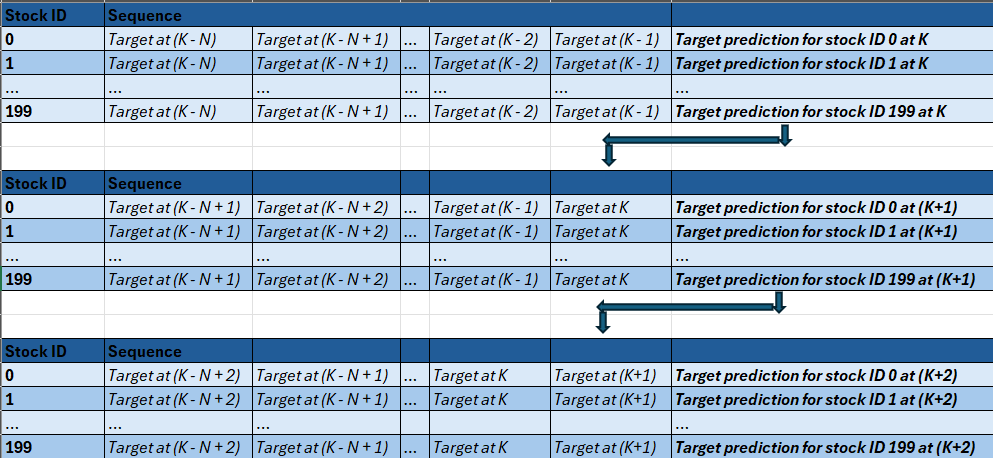

In [1]:
import pandas as pd

import os
import numpy as np
import math
from matplotlib import pyplot as plt
import time

from scipy.stats import norm, levene, f_oneway, zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.metrics import r2_score

import warnings
import json

from torch import nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch.utils.data.sampler import Sampler
import torch

import warnings
warnings.filterwarnings('ignore')

## 1) Loading and Initializing wrangled data

In [2]:
torch.manual_seed(42)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

dataset_df = pd.read_csv('train_wrangled.csv')
#dataset_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_wrangled.csv")

In [3]:
#Changing datatypes to reduce memory consumption.
dataset_df['stock_id'] = dataset_df['stock_id'].astype('int16')
dataset_df['date_id'] = dataset_df['date_id'].astype('int16')
dataset_df['seconds_in_bucket'] = dataset_df['seconds_in_bucket'].astype('int16')
dataset_df['imbalance_buy_sell_flag'] = dataset_df['imbalance_buy_sell_flag'].astype('int8')
dataset_df['time_id'] = dataset_df['time_id'].astype('int16')
dataset_df['target'] = dataset_df['target'].astype('float16') #Changed from float32 because of RAM constraints.

## 2) Using the ACF and PACF

### 2.1) Plotting the ACF and PACF.

In [4]:
NUM_LAGS = 110

In [5]:
stock_id = 6
#stock_id = 10
#stock_id = 100
#stock_id = 199

Visual inspection of ACF plot for stock ID 6: -


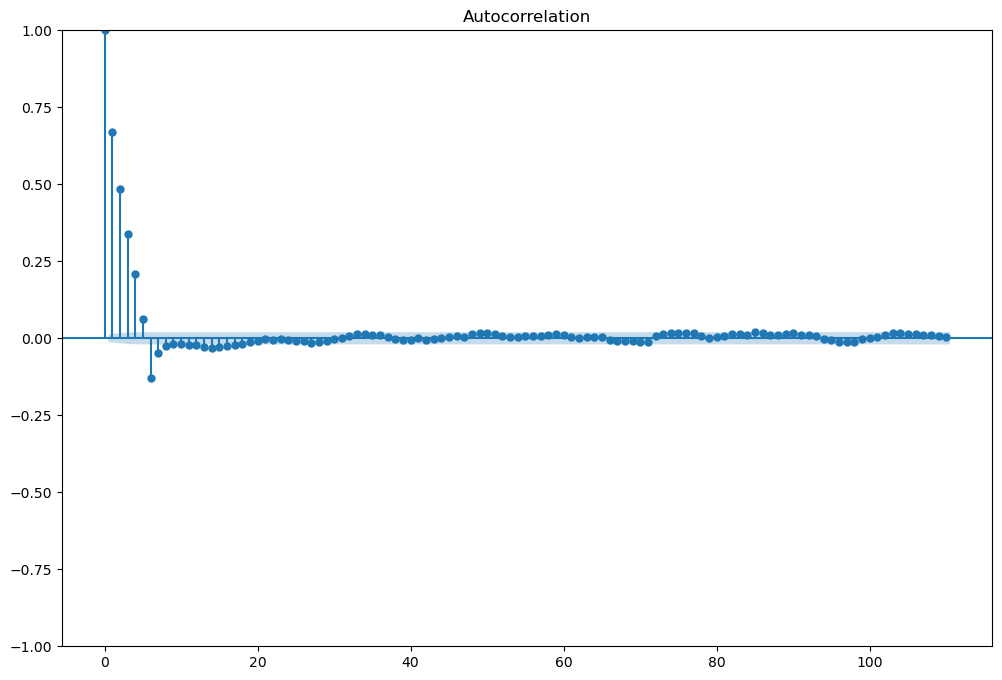

In [6]:
print(f'Visual inspection of ACF plot for stock ID {stock_id}: -')
#Creating the ACF plot for target prices for stock ID 1.
fig, ax = plt.subplots(figsize=(12, 8))
target_vals = dataset_df[(dataset_df['stock_id'] == stock_id)]['target']
acf_plot = plot_acf(target_vals, lags=NUM_LAGS, ax=ax)

Visual inspection of PACF plot for stock ID 6: -


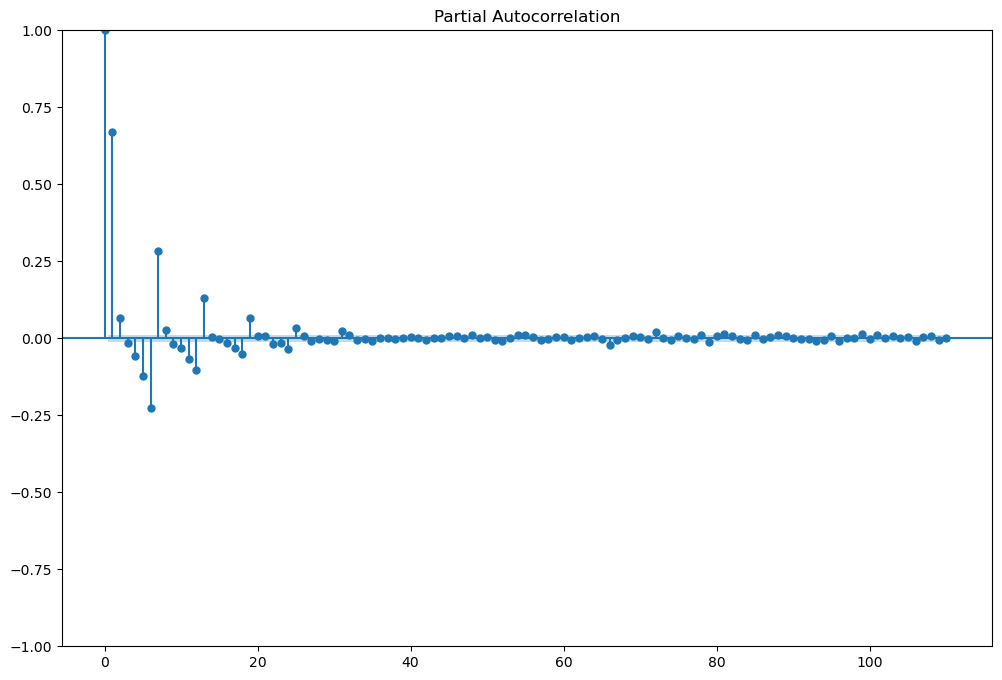

In [7]:
print(f'Visual inspection of PACF plot for stock ID {stock_id}: -')
#Creating the PACF plot for target prices for stock ID 1.
fig, ax = plt.subplots(figsize=(12, 8))
target_vals = dataset_df[(dataset_df['stock_id'] == stock_id)]['target']
acf_plot = plot_pacf(target_vals, lags=NUM_LAGS, ax=ax)

<b>Observation</b>: -<br>
The visual inspection of the ACF plots for various stock IDs reveals a great degree of similarity in pattern.

The visual inspection of the PACF plots for various stock IDs also reveals a great degree of similarity in pattern.

<b>Approach going ahead</b>: -<br>
The approach ahead is based on the following understanding of ACF and PACF: -
1) The ACF represents the (direct + indirect) correlation of a lag with the target.<br>
2) The PACF represents the direct correlation of a lag with the target.<br>

<b>LSTM models - How they work? :-</b><br>
In LSTM, a prediction is generated at the final time-step of the sequence based on the following three components: -<br>
1) <u>Input at the final step</u>: -This is the target at the most recent time-step.<br>
2) <u>Hidden state from the previous time step</u>: -This encapsulates inputs from all previous time steps in the sequence.<br>
3) <u>Cell state from the previous time step</u>: -This serves as the long-term memory of the model, preserving relevant information from earlier in the sequence.<br>

<b>Approach: -</b><br>
1) <u>Input sequence construction</u>: - The input sequence of the model will be consist of lagged target values that exhibit high ACF. This will enable the model to refine its prediction based on these lagged targets.<br>
2) <u>Cell state utilization</u>: - The cell state will enable the model to retain important lagged values that exhibit high PACF. This allows the model to refine its predictions by capturing direct relationships with specific lags that are particularly significant.
3) <u>Final time-step prediction</u>: - At the final time-step, the model will generate a prediction based on the current input and appropriate lagged target values.

### 2.2) Funtion to obtain lags that have ACF and PACF above a certain threshold up to a certain number of lags in the past.

In [8]:
def get_high_acf_pacf_lags(dataset_df, corr_threshold = 0.20, num_lags = 50):

    pacf_corr_dict = {}
    acf_corr_dict = {}

    num_stock_ids = len(dataset_df['stock_id'].unique())

    #Go through all the stock IDs.
    for stock_id in range(0, num_stock_ids):

        #For the current stock ID, maintain list of lag values with high direct and indirect correlation respectively.
        pacf_corr_dict[stock_id] = []
        acf_corr_dict[stock_id] = []
    
        stock_id_dataset_df = dataset_df[dataset_df['stock_id'] == stock_id]
    
        #Determine the ACF and partial ACF values for the target for all lags up to NUM_LAGS.
        acf_values = acf(stock_id_dataset_df['target'], nlags=NUM_LAGS)
        pacf_values = pacf(stock_id_dataset_df['target'], nlags=NUM_LAGS)
    
        #Go through all lags from 1 to NUM_LAG.
        for lag_no in range(1, NUM_LAGS+1):
    
            #Maintain list of lag values that have high direct correlation.
            if ((pacf_values[lag_no] >= CORR_THRESHOLD) or (pacf_values[lag_no] <= -CORR_THRESHOLD)):
                pacf_corr_dict[stock_id].append(lag_no)
            
            #Maintain list of lag values that have high indirect correlation.
            if ((acf_values[lag_no] >= CORR_THRESHOLD) or (acf_values[lag_no] <= -CORR_THRESHOLD)):
                acf_corr_dict[stock_id].append(lag_no)

    return pacf_corr_dict, acf_corr_dict

## 3) Data transformation

### 3.1) Splitting data into training, validation and test dataframes

In [9]:
lstm_model1_data_df = dataset_df[['stock_id', 'date_id', 'time_id', 'target']].copy()
#del dataset_df

In [10]:
#Creating training dataframe.
lstm_model1_train_df = lstm_model1_data_df[lstm_model1_data_df['date_id'] <= 474].copy()
lstm_model1_train_df = lstm_model1_train_df.drop(['date_id'], axis = 1)

#Creating validation dataframe.
lstm_model1_val_df = lstm_model1_data_df[(lstm_model1_data_df['date_id'] >= 475) & (lstm_model1_data_df['date_id'] <= 477)].copy()
lstm_model1_val_df = lstm_model1_val_df.drop(['date_id'], axis = 1)

#Creating test dataframe.
lstm_model1_test_df = lstm_model1_data_df[(lstm_model1_data_df['date_id'] >= 478) & (lstm_model1_data_df['date_id'] <= 480)].copy()
lstm_model1_test_df = lstm_model1_test_df.drop(['date_id'], axis = 1)

del lstm_model1_data_df

In [11]:
print(f'Training shape = {lstm_model1_train_df.shape}')
print(f'Validation shape = {lstm_model1_val_df.shape}')
print(f'Test shape = {lstm_model1_test_df.shape}')

Training shape = (5172090, 3)
Validation shape = (33000, 3)
Test shape = (33000, 3)


### 3.2) Converting stock IDs to their one-hot vector representations and dropping 'stock_id' column.

In [12]:
lstm_model1_train_one_hot_df = pd.concat([lstm_model1_train_df, pd.get_dummies(lstm_model1_train_df['stock_id'], prefix = 'stock_id').astype('int8')], axis = 1)
lstm_model1_train_one_hot_df = lstm_model1_train_one_hot_df.drop(['stock_id'], axis = 1)
print('Training dataframe after inclusion of one-hot vector as stock ID embedding: -')
lstm_model1_train_one_hot_df.head()

Training dataframe after inclusion of one-hot vector as stock ID embedding: -


,time_id,target,stock_id_0,stock_id_1,stock_id_2,stock_id_3,stock_id_4,stock_id_5,stock_id_6,stock_id_7,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
0,0,-3.029297,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,-5.519531,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,-8.390625,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-4.011719,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,-7.351562,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
lstm_model1_val_one_hot_df = pd.concat([lstm_model1_val_df, pd.get_dummies(lstm_model1_val_df['stock_id'], prefix = 'stock_id').astype('int8')], axis = 1)
lstm_model1_val_one_hot_df = lstm_model1_val_one_hot_df.drop(['stock_id'], axis = 1)
print('Validation dataframe after inclusion of one-hot vector as stock ID embedding: -')
lstm_model1_val_one_hot_df.head()

Validation dataframe after inclusion of one-hot vector as stock ID embedding: -


,time_id,target,stock_id_0,stock_id_1,stock_id_2,stock_id_3,stock_id_4,stock_id_5,stock_id_6,stock_id_7,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
5171980,26125,-4.878906,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5171981,26125,0.669922,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5171982,26125,14.859375,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5171983,26125,-1.729492,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5171984,26125,-3.429688,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
lstm_model1_test_one_hot_df = pd.concat([lstm_model1_test_df, pd.get_dummies(lstm_model1_test_df['stock_id'], prefix = 'stock_id').astype('int8')], axis = 1)
lstm_model1_test_one_hot_df = lstm_model1_test_one_hot_df.drop(['stock_id'], axis = 1)
print('Test dataframe after inclusion of one-hot vector as stock ID embedding: -')
lstm_model1_test_one_hot_df.head()

Test dataframe after inclusion of one-hot vector as stock ID embedding: -


,time_id,target,stock_id_0,stock_id_1,stock_id_2,stock_id_3,stock_id_4,stock_id_5,stock_id_6,stock_id_7,...,stock_id_190,stock_id_191,stock_id_192,stock_id_193,stock_id_194,stock_id_195,stock_id_196,stock_id_197,stock_id_198,stock_id_199
5204980,26290,-5.429688,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5204981,26290,-1.870117,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5204982,26290,-0.090027,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5204983,26290,-7.609375,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5204984,26290,-3.291016,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.3) Functions to transform the data suitable for training and testing the various LSTM models.

In [15]:
#Convert stock ID dataframe to sequences and their associated labels
def convert_sid_dataframe_to_seq_labels_array(data_df, lag_vals_list, seq_len, step_size, stock_rep_type = 1):

    feats_list = []
    labels_list = []
    
    data_arr = data_df.sort_values(by = ['time_id'], ascending = True).to_numpy()
    
    highest_lag = max(lag_vals_list)
    window_size = highest_lag
    
    filter_list = []
    filter_list = lag_vals_list.copy()
    
    count = 0
    
    #for index in range(0, data_arr.shape[0] - highest_lag, step_size):
    for index in range(data_arr.shape[0] - step_size, 0, -step_size):
    
        if step_size > 1:
            target_index = index + window_size
            index_vals_list = list(range(index, target_index))
            index_vals_list = [index_val for index_val in index_vals_list if target_index - index_val in filter_list]
        
        else:
            index_vals_list = [(index+val) for val in filter_list]
        
        rows =  [[seq] for seq in data_arr[index_vals_list]]
        if step_size == 1:
            rows.reverse()
        feats_list.append(rows)
        
        if ((stock_rep_type == 1) or (stock_rep_type == 2)):
            label = data_arr[index+window_size][1]
        else:
            label = data_arr[index+window_size][2]
        
        labels_list.append(label)
        
        count += 1
    
    feats_arr = np.array(feats_list)
    feats_arr = feats_arr.reshape(feats_arr.shape[0], feats_arr.shape[1], feats_arr.shape[3])
    if ((stock_rep_type == 1) or (stock_rep_type == 2)):
        feats_arr = feats_arr[:, :, :]
    else:
        feats_arr = feats_arr[:, :, 1:]
    
    labels_arr = np.array(labels_list).reshape(-1, 1)
    
    return feats_arr, labels_arr

In [16]:
#Convert stock ID dataframe to sequences and their associated labels
def convert_dataframe_to_seq_labels_array(data_df, lag_vals_list, stock_rep_type = 1):

    #The sequence must contain the following lags.
    all_seq_feat_train_arr = []
    all_seq_train_label_arr = []

    step_size = (max(lag_vals_list) + 1)
    seq_len = len(lag_vals_list)

    for stock_id in range(0, 200):

        #Stock ID NOT represented in binary form.
        if stock_rep_type == 1:

            col_name = 'stock_id_' + str(stock_id)
            curr_seq_feat_train_arr, curr_seq_train_label_arr = convert_sid_dataframe_to_seq_labels_array(data_df[(data_df[col_name] == True)], lag_vals_list, seq_len, step_size)
            
        ##Stock ID represented in binary form.
        elif stock_rep_type == 2:
            stock_id_bin_list = [int(element) for element in list(format(stock_id, f'0{8}b'))]
            curr_seq_feat_train_arr, curr_seq_train_label_arr = convert_sid_dataframe_to_seq_labels_array(data_df[(data_df['stock_id_bit_7'] == stock_id_bin_list[0]) & (data_df['stock_id_bit_6'] == stock_id_bin_list[1]) & (data_df['stock_id_bit_5'] == stock_id_bin_list[2]) & (data_df['stock_id_bit_4'] == stock_id_bin_list[3]) & (data_df['stock_id_bit_3'] == stock_id_bin_list[4]) & (data_df['stock_id_bit_2'] == stock_id_bin_list[5]) & (data_df['stock_id_bit_1'] == stock_id_bin_list[6]) & (data_df['stock_id_bit_0'] == stock_id_bin_list[7])], lag_vals_list, seq_len, step_size, stock_rep_type)

        elif stock_rep_type == 3:
            curr_seq_feat_train_arr, curr_seq_train_label_arr = convert_sid_dataframe_to_seq_labels_array(data_df[data_df['stock_id'] == stock_id], lag_vals_list, seq_len, step_size, stock_rep_type)

        else:
            pass

    all_seq_feat_train_arr.append(curr_seq_feat_train_arr)
    all_seq_train_label_arr.append(curr_seq_train_label_arr)
    
    seq_feat_train_arr = np.concatenate(all_seq_feat_train_arr, axis=0)
    seq_label_train_arr = np.concatenate(all_seq_train_label_arr, axis=0)

    return seq_feat_train_arr, seq_label_train_arr

In [17]:
class DivideBy100Scaler(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        X = np.array(X)
        return X/100
    
    def inverse_transform(self, X):
        return X * 100

In [18]:
def standardize_target_vals(seq_feat_train_arr):
    
    scaler = DivideBy100Scaler()
    #scaler = StandardScaler()
    slices_to_scale = seq_feat_train_arr[:, :, [1]] #Shape = (646389, 6, 1)

    #This changes shape to 3,878,334x1.
    slices_to_scale = slices_to_scale.reshape(-1, 1)

    #Standardize the data using the scaler.
    scaled_slices = scaler.fit_transform(slices_to_scale)

    #Reshape it to the orginal shape.
    scaled_slices = scaled_slices.reshape(seq_feat_train_arr[:, :, [0]].shape)

    #Set the scaled data back to the original array.
    seq_feat_train_arr[:, :, [1]] = scaled_slices

    return scaler

In [19]:
class StockTimeSeriesDataset(Dataset):

    def __init__(self, feat_tensor, label_tensor):

        self.dict_list = []
        
        for index, curr_seq in enumerate(feat_tensor):
            curr_dict = {}
            curr_dict['index'] = index
            curr_dict['seq_start_time_id'] = int(curr_seq[0, 0])
            curr_dict['feat_seq'] = curr_seq[:, 1:]
            curr_dict['feat_label'] = label_tensor[index]
            
            self.dict_list.append(curr_dict)

        self.tensor_size = len(self.dict_list)

    def __getitem__(self, index):

        seq_dict = self.dict_list[index]
        return seq_dict['feat_seq'], seq_dict['feat_label']

    def __len__(self):

        return self.tensor_size

In [20]:
class TimeIDBasedBatchSampler(Sampler):

    def __init__(self, dict_list):
    
        self.seq_grouped_by_time_id = {}
        
        for curr_dict in dict_list:
        
            seq_start_time_id = curr_dict['seq_start_time_id']
            
            if seq_start_time_id in self.seq_grouped_by_time_id:
                self.seq_grouped_by_time_id[seq_start_time_id].append(curr_dict["index"])
            
            else:
                self.seq_grouped_by_time_id[seq_start_time_id] = [curr_dict["index"]]
        
    def __iter__(self):
        batch = []
        
        for seq_start_time_id, indices in self.seq_grouped_by_time_id.items():
            yield indices
    
    def __len__(self):
        return len(self.seq_grouped_by_time_id)

## 4) Function for LSTM Models

### 4.1) Class that instantiates LSTM model

In [21]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_preds):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # Fully connected layer for final prediction
        self.fc = nn.Linear(hidden_size, num_preds)

    def forward(self, x):

        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
    def get_num_params(self):
        
        return sum(p.numel() for p in self.parameters())

### 4.2) Function to train the model for one epoch 

In [22]:
def train_one_epoch(model, loss_function, optimizer, epoch, dataset_loader):

    model.train(True)

    total_loss = 0
    avg_loss = 0

    for batch_index, batch in enumerate(dataset_loader):
        batch_features = batch[0]
        batch_labels = batch[1]
        
        output = model(batch_features)
        
        batch_loss = loss_function(output, batch_labels)
        total_loss += batch_loss.item()
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    return round((total_loss/len(dataset_loader)), 3)

### 4.3) Function to validate the model after one epoch

In [23]:
def validate_one_epoch(model, loss_function, optimizer, val_new_df, prec_time_id_target_dict, target_label_dict, lag_vals_list, seq_len, scaler, ret_mad_per_time_id = False, stock_rep_type = 1):
    
    model.train(False)
    
    total_loss = 0
    total_loss_mean = 0
    
    num_stock_ids = 200
    
    if stock_rep_type == 1:
        num_features = 201
    
    elif stock_rep_type == 2:
        num_features = 9
    
    else:
        num_features = 1
    
    mean_target = val_new_df['target'].mean()
    mean_target_tensor = torch.tensor(np.array([mean_target] * num_features).reshape(1, num_features)).float()
    
    highest_lag_val = max(lag_vals_list)
    lag_vals_list_sorted = sorted(lag_vals_list, reverse=True)
    min_time_id = int(min(val_new_df['time_id']))
    max_time_id = int(max(val_new_df['time_id']))
    loss_per_time_id_dict = {}
    
    time_id_index = 0
    
    #This loop will construct the sequences (consisting of all lagged targets) for all stock IDs and all time IDs.
    #We are ignoring the first 'highest_lag_val' time IDs as they originated from the training data.
    for time_id in range((min_time_id+highest_lag_val), max_time_id + 1):

        #Determine the lag time IDs for the current time ID.
        curr_lag_time_ids = [(time_id - lag_val) for lag_val in lag_vals_list_sorted]

        curr_time_id_seq = np.zeros((200, seq_len, num_features))

        #This loop will construct the sequence (consisting of all lagged targets) for all the stock IDs and the current time ID.
        for stock_id in range(num_stock_ids):

            if stock_rep_type == 1:
                stock_id_repr_arr = np.zeros(200).astype(int)
                stock_id_repr_arr[stock_id] = 1
                
            elif stock_rep_type == 2:
                stock_id_bin_list = [int(element) for element in list(format(stock_id, f'0{8}b'))]
                stock_id_repr_arr = np.array(stock_id_bin_list)

            else:
                stock_id_repr_arr = np.array([])

            curr_stock_time_id_seq = None

            #This loop will construct the sequence (consisting of all lagged targets) for the current stock ID and time ID.
            index = 0
            for lag_time_id in curr_lag_time_ids:

                #Within a single iteration of this loop, we are constructing the features (dimension 201) for the current
                #stock and lagged time ID.
                prec_time_id_target = prec_time_id_target_dict[(stock_id, lag_time_id)]
                
                prec_time_id_target = scaler.transform([[prec_time_id_target]])
                prec_time_id_target = np.squeeze(prec_time_id_target)
                
                curr_stock_time_id_arr = np.concatenate([[prec_time_id_target], stock_id_repr_arr])
                curr_stock_time_id_arr = curr_stock_time_id_arr.reshape(1, num_features)
                
                if curr_stock_time_id_seq is None:
                    curr_stock_time_id_seq = curr_stock_time_id_arr
                else:
                    curr_stock_time_id_seq = np.concatenate([curr_stock_time_id_seq, curr_stock_time_id_arr], axis = 0)#dim = 5X201
                
                index += 1

            #print(curr_time_id_seq.shape)
            curr_time_id_seq[stock_id] = curr_stock_time_id_seq

            curr_time_id_seq_tensor = torch.tensor(curr_time_id_seq).float()

        #Determine the target labels associated with the current time ID.
        curr_time_id_target_labels = target_label_dict[time_id]
        curr_time_id_target_labels_tensor = torch.tensor(curr_time_id_target_labels).float().reshape(200, 1)
        
        with torch.no_grad():
            output = model(curr_time_id_seq_tensor)
            
            batch_loss = loss_function(output, curr_time_id_target_labels_tensor)
            loss_per_time_id_dict[time_id] = batch_loss
            total_loss += batch_loss.item()
            
            batch_loss_using_mean = loss_function(mean_target_tensor, curr_time_id_target_labels_tensor)
            total_loss_mean += batch_loss_using_mean.item()
            
            for stock_id in range(200):
                prec_time_id_target_dict[(stock_id, time_id)] = output[stock_id]

        time_id_index += 1

    if ret_mad_per_time_id == False:
        return round(total_loss/(max_time_id - (min_time_id+highest_lag_val) + 1), 3), round(total_loss_mean/(max_time_id - (min_time_id+highest_lag_val) + 1), 3)

    else:
        return round(total_loss/(max_time_id - (min_time_id+highest_lag_val) + 1), 3), round(total_loss_mean/(max_time_id - (min_time_id+highest_lag_val) + 1), 3), loss_per_time_id_dict

### 4.4) Function to build and train the models.

In [24]:
def build_and_train_models(lstm_model1_val_train_one_hot_df, train_dataset, scaler, target_label_dict, input_size, lag_vals_list, prec_time_id_target_dict, hidden_size_list, num_layer_list, num_preds, num_epochs, learning_rate, stock_rep_type):
    
    best_val_mad = None
    best_val_mod = None
    optimum_num_epochs = None
    seq_len = len(lag_vals_list)

    for hidden_size in hidden_size_list:
        
        for num_layer in num_layer_list:

            #Instantiate the model
            model = LSTMModel(input_size, hidden_size = hidden_size, num_layers = num_layer, num_preds = 1)
            
            print(f'Model with hidden size = {hidden_size}, number of layers = {num_layer}, number of parameters = {model.get_num_params()}')
            
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            loss_function = nn.L1Loss()

            train_dataset_loader = DataLoader(train_dataset, batch_sampler=stock_data_sampler)
            
            curr_mod_best_val_mad = None
            for epoch in range(1, NUM_EPOCHS+1):
            
                train_mad = train_one_epoch(model, loss_function, optimizer, epoch, train_dataset_loader)
                val_mad, val_mean_mad = validate_one_epoch(model, loss_function, optimizer, lstm_model1_val_train_one_hot_df, prec_time_id_target_dict, target_label_dict, lag_vals_list, seq_len, scaler, False, stock_rep_type=stock_rep_type)

                print(f'Epoch {epoch}: Training loss = {train_mad}, Validation loss = {val_mad}, Validation loss based on target mean = {val_mean_mad}')

                if curr_mod_best_val_mad is None:
                    curr_mod_best_val_mad = val_mad

                else:
                    if val_mad >= curr_mod_best_val_mad:
                        break
                    curr_mod_best_val_mad = val_mad
            
            if best_val_mod is None:
                best_val_mad = curr_mod_best_val_mad
                best_val_mod = model
                optimum_num_epochs = epoch - 1
            
            elif best_val_mad > curr_mod_best_val_mad:
                best_val_mad = curr_mod_best_val_mad
                best_val_mod = model
                optimum_num_epochs = epoch - 1
            
            else:
                pass

    return best_val_mad, best_val_mod, optimum_num_epochs

## 5) Build single LSTM model for all stock IDS - stock IDs represented as one-hot vector
The model will be trained on training data consisting of input sequences and labels such as the following: -<br>
   <pre>   <b>Sequence</b>                                                           <b>Label (Target at current Time ID)</b>
   Lag 10 Target         Lag 9 Target               Lag 1 Target
        +           ->        +        -> ...... ->      +         -> Predicted Target
   one-hot vector        one-hot vector             one-hot vector</pre>
<u>Model parameters: -</u><br>
- Input size = 201 (1 feature for target value + one-hot vector of dimension 200 = 201)<br>
- Hidden size = [4, 8, 16, 32]<br>
- Number of layers = [1]<br>

<u>Model hyper-parameters: -</u><br>
 - Number of epochs = 10
 - Learning rate = 0.0005

In [41]:
input_size = 201

num_layer_list = [1]
hidden_size_list = [4, 8, 16, 32]
num_preds = 1

NUM_EPOCHS = 10
LEARNING_RATE = 0.0001

### 5.1) Build single LSTM model for all stock IDS - Previous 10 lagged targets.
The previous 10 lagged targets are chosen without without considering ACF.<br>

Based on the above, each sequence will have the dimension 10x201.

#### 5.1.1) Preparing training input sequences

In [42]:
def prep_train_input_seqs(best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, best_lag_vals_list, lag_vals_list, lstm_model1_train_one_hot_df, stock_rep_type = 1):
    
    #Convert training dataframes to sequences
    print('\nConverting the training dataframes to sequences...')
    seq_feat_train_arr, seq_label_train_arr = convert_dataframe_to_seq_labels_array(lstm_model1_train_one_hot_df, lag_vals_list, stock_rep_type)
    
    #Standardize the lagged target values.
    print('Standardizing the target values in the training sequences...')
    scaler = standardize_target_vals(seq_feat_train_arr)
    
    #Preparing training sequences for LSTM
    seq_feat_train_tensor = torch.tensor(seq_feat_train_arr).float()
    seq_label_train_tensor = torch.tensor(seq_label_train_arr).float()
    train_dataset = StockTimeSeriesDataset(seq_feat_train_tensor, seq_label_train_tensor)
    stock_data_sampler = TimeIDBasedBatchSampler(train_dataset.dict_list)

    return train_dataset, stock_data_sampler, scaler

In [43]:
best_val_mad_across_lag_vals = None
best_val_mod_across_lag_vals = None
optimum_num_epochs_across_lag_vals = None
best_lag_vals_list = None

In [44]:
lag_vals_list = [lag_val for lag_val in range(10, 0, -1)]
print(f'\nLag values = {lag_vals_list}')

train_dataset, stock_data_sampler, scaler = prep_train_input_seqs(best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, best_lag_vals_list, lag_vals_list, lstm_model1_train_one_hot_df)


Lag values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

Converting the training dataframes to sequences...
Standardizing the target values in the training sequences...


#### 5.1.2) Preparing validation input sequences, building and training model

In [45]:
def prep_val_data_and_train(train_dataset, stock_data_sampler, scaler, lag_vals_list, lstm_model1_train_one_hot_df, lstm_model1_val_one_hot_df, learning_rate, best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, stock_rep_type = 1):

    #-------Preparing validation data--------------
    print('Converting the validation dataframes to sequences...')
    #The objective here is to prepend the validation dataframe with the records associated with the highest few time IDS in the training records.
    #These training records (the ones being appended) will be a part of the validation sequences.
    highest_lag_val = max(lag_vals_list)
    
    #Determine the records associated with the 'highest_lag_val' highest time IDs in the training data.
    highest_train_time_id = max(lstm_model1_train_one_hot_df['time_id'].unique())
    train_last_time_ids_df = lstm_model1_train_one_hot_df[lstm_model1_train_one_hot_df['time_id'] > highest_train_time_id-highest_lag_val]
    
    #print(f'Dimension of the validation dataframe before having the training records (for the highest {highest_lag_val} time IDs) prepended to it = {lstm_model1_val_one_hot_df.shape}')
    lstm_model1_val_train_one_hot_df = pd.concat([train_last_time_ids_df, lstm_model1_val_one_hot_df], axis = 0)
    #print(f'Dimension of the validation dataframe after having the training records (for the highest {highest_lag_val} time IDs) prepended to it = {lstm_model1_val_one_hot_df.shape}')
    
    #The objective here is to prepare the target labels for the validation dataframe (by time ID).
    #This will store actual target values in the form - target_label_dict[(Time ID)] = [actual_target_stock_0, ..., actual_target_stock_199]
    target_label_dict = {}
    lowest_val_time_id = min(lstm_model1_val_train_one_hot_df['time_id']) + highest_lag_val
    higher_val_time_id = max(lstm_model1_val_train_one_hot_df['time_id'])
    
    #Loop through all the time IDs in the validation data set.
    for time_id in range(lowest_val_time_id, higher_val_time_id+1):
        
        target_label_dict[time_id] = list(lstm_model1_val_train_one_hot_df[lstm_model1_val_train_one_hot_df['time_id'] == time_id]['target'])
    
    #The objective here to prepare the dictionary that contains the target values for the preceding time IDs. This is useful for preparing the sequence
    #for each validation time ID.
    #To begin with, this dictionary will contain the target values for those IDs only that originate from the training data. The dictionary will store data
    #in the form - prec_time_id_target_dict{(Stock ID, Time ID)} = target/predicted target
    prec_time_id_target_dict = {}
    
    stock_id = int(0)
    for index, row in train_last_time_ids_df.iterrows():
    
        prec_time_id_target_dict[(stock_id, int(row['time_id']))] = row['target']
    
        if stock_id < 199:
            stock_id += 1
        else:
            stock_id = 0
    #-------End of validation data preparation--------------
    
    best_val_mad_curr_lag_vals, best_val_mod_curr_lag_vals, optimum_num_epochs_curr_lag_vals = build_and_train_models(lstm_model1_val_train_one_hot_df, train_dataset, scaler, target_label_dict, input_size, lag_vals_list, prec_time_id_target_dict, hidden_size_list, num_layer_list, num_preds, NUM_EPOCHS, learning_rate, stock_rep_type)
    
    if best_val_mad_across_lag_vals is None:
    
        best_val_mad_across_lag_vals = best_val_mad_curr_lag_vals
        best_val_mod_across_lag_vals = best_val_mod_curr_lag_vals
        optimum_num_epochs_across_lag_vals = optimum_num_epochs_curr_lag_vals
        best_lag_vals_list = lag_vals_list
    
    elif best_val_mad_across_lag_vals > best_val_mad_curr_lag_vals:
    
        best_val_mad_across_lag_vals = best_val_mad_curr_lag_vals
        best_val_mod_across_lag_vals = best_val_mod_curr_lag_vals
        optimum_num_epochs_across_lag_vals = optimum_num_epochs_curr_lag_vals
        best_lag_vals_list = lag_vals_list
    
    else:
        pass

    return best_val_mod_curr_lag_vals

In [46]:
%time
model1 = prep_val_data_and_train(train_dataset, stock_data_sampler, scaler, lag_vals_list, lstm_model1_train_one_hot_df, lstm_model1_val_one_hot_df, LEARNING_RATE, best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals)

CPU times: total: 0 ns
Wall time: 0 ns
Converting the validation dataframes to sequences...
Model with hidden size = 4, number of layers = 1, number of parameters = 3317
Epoch 1: Training loss = 5.959, Validation loss = 5.445, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.956, Validation loss = 5.446, Validation loss based on target mean = 5.444
Model with hidden size = 8, number of layers = 1, number of parameters = 6761
Epoch 1: Training loss = 5.961, Validation loss = 5.446, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.956, Validation loss = 5.446, Validation loss based on target mean = 5.444
Model with hidden size = 16, number of layers = 1, number of parameters = 14033
Epoch 1: Training loss = 5.957, Validation loss = 5.444, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.949, Validation loss = 5.445, Validation loss based on target mean = 5.444
Model with hidden size = 32, number of layers = 1, number of

### 5.2) Build single LSTM model for all stock IDS - Lagged targets with ACF higher than 0.2
The sequence will contained lagged targets - Attempt with the lagged targets with ACF higher than 0.2.<br>

Based on the above, each sequence will have the dimension sx201 where s will be the number of lagged values with ACF higher than 0.2.

#### 5.2.1) Preparing training input sequences

In [31]:
def get_best_lag_vals(dataset_df, corr_threshold):

    NUM_LAGS = 50

    #Determine lags with indirect correlation higher than 0.1
    _, indir_corr_dict = get_high_acf_pacf_lags(dataset_df, corr_threshold = CORR_THRESHOLD, num_lags = NUM_LAGS)
    
    lags_freq_dict = {}
    
    largest_freq = 0
    lags_largest_freq = ()
    
    print('Indirect lag values for stock IDs: -')
    for stock_id in indir_corr_dict.keys():
        
        if tuple(indir_corr_dict[stock_id]) in lags_freq_dict.keys():
            lags_freq_dict[tuple(indir_corr_dict[stock_id])] += 1
        else:
            lags_freq_dict[tuple(indir_corr_dict[stock_id])] = 1
    
        if lags_freq_dict[tuple(indir_corr_dict[stock_id])] > largest_freq:
            largest_freq = lags_freq_dict[tuple(indir_corr_dict[stock_id])]
            lags_largest_freq = tuple(indir_corr_dict[stock_id])
    
    print(f"The following are the relevant lags (keys) and their frequencies (values) with correlation threshold of {CORR_THRESHOLD}.")
    print(lags_freq_dict)
    print(f"\nThe lag values list with the largest frequency ({largest_freq}) is {lags_largest_freq}.")

    return lags_largest_freq

In [32]:
CORR_THRESHOLD = 0.2

lags_val_list = get_best_lag_vals(dataset_df, CORR_THRESHOLD)

Indirect lag values for stock IDs: -
The following are the relevant lags (keys) and their frequencies (values) with correlation threshold of 0.2.
{(1, 2, 3, 4): 186, (1, 2, 3): 11, (1, 2, 3, 4, 5): 2, (1, 2, 3, 6): 1}

The lag values list with the largest frequency (186) is (1, 2, 3, 4).


In [33]:
train_dataset, stock_data_sampler, scaler = prep_train_input_seqs(best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, best_lag_vals_list, lag_vals_list, lstm_model1_train_one_hot_df)


Converting the training dataframes to sequences...
Standardizing the target values in the training sequences...


#### 5.2.2) Preparing validation input sequences, building and training model

In [34]:
%time
model2 = prep_val_data_and_train(train_dataset, stock_data_sampler, scaler, lag_vals_list, lstm_model1_train_one_hot_df, lstm_model1_val_one_hot_df, LEARNING_RATE, best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals)

CPU times: total: 0 ns
Wall time: 0 ns
Converting the validation dataframes to sequences...
Model with hidden size = 4, number of layers = 1, number of parameters = 3317
Epoch 1: Training loss = 5.98, Validation loss = 5.455, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.973, Validation loss = 5.453, Validation loss based on target mean = 5.444
Epoch 3: Training loss = 5.965, Validation loss = 5.45, Validation loss based on target mean = 5.444
Epoch 4: Training loss = 5.958, Validation loss = 5.448, Validation loss based on target mean = 5.444
Epoch 5: Training loss = 5.949, Validation loss = 5.447, Validation loss based on target mean = 5.444
Epoch 6: Training loss = 5.941, Validation loss = 5.446, Validation loss based on target mean = 5.444
Epoch 7: Training loss = 5.932, Validation loss = 5.446, Validation loss based on target mean = 5.444
Model with hidden size = 8, number of layers = 1, number of parameters = 6761
Epoch 1: Training loss = 5.968, Validati

## 6) Repeating model creation and training after using 8-bit binary representations of stock IDs.
<u>Model parameters: -</u><br>
- Input size = 9 (1 feature for target value + 8-bit binary stock ID representation)<br>
- Input sequence length = 10
- Hidden size = [4, 8, 16]<br>
- Number of layers = [1]<br>

<u>Model hyper-parameters: -</u><br>
 - Number of epochs = 10
 - Learning rate = 0.0005= 0.0005

### 6.1) Representing stock IDs with their binary representations
The model will be trained on training data consisting of input sequences and labels such as the following: -<br>
   <pre>   <b>Sequence</b>                                                           <b>Label (Target at current Time ID)</b>
   Lag 10 Target         Lag 9 Target               Lag 1 Target
        +           ->        +        -> ...... ->      +         -> Predicted Target
   8-bit vector          8-bit vector               8-bit vector</pre>
<u>Model parameters: -</u><br>
- Input size = 9 (1 feature for target value + 8-bit representation = 9)<br>
- Hidden size = [4, 8, 16]<br>
- Number of layers = [1]<br>

<u>Model hyper-parameters: -</u><br>
 - Number of epochs = 10
 - Learning rate = 0.0001

#### 6.1.1) Including binary representation in training data

In [35]:
# Define the number of bits (columns) for binary representation
NUM_BITS = 8

In [36]:
#Convert 'stock_id' to binary and ensure all numbers have 'num_bits' bits
lstm_model1_train_df['stock_id_binary'] = lstm_model1_train_df['stock_id'].apply(lambda x: format(x, f'0{NUM_BITS}b'))

#Add new columns where each binary digit corressponds to a separate integer columns.
binary_columns = lstm_model1_train_df['stock_id_binary'].apply(lambda x: pd.Series(list(x)).astype(int))

#Give columns appropriate names
binary_columns.columns = [f'stock_id_bit_{NUM_BITS - 1 - i}' for i in range(NUM_BITS)]

#Add the binary embedding back to the dataframe.
lstm_model1_train_bin_df = pd.concat([lstm_model1_train_df, binary_columns], axis=1)

#Drop columns that are no longer necessary.
lstm_model1_train_bin_df = lstm_model1_train_bin_df.drop(['stock_id', 'stock_id_binary'], axis=1)
lstm_model1_train_df = lstm_model1_train_df.drop(['stock_id_binary'], axis = 1)

In [37]:
print('Training dataframe after inclusion of binary representation as stock ID embedding: -')
lstm_model1_train_bin_df.head(10)

Training dataframe after inclusion of binary representation as stock ID embedding: -


,time_id,target,stock_id_bit_7,stock_id_bit_6,stock_id_bit_5,stock_id_bit_4,stock_id_bit_3,stock_id_bit_2,stock_id_bit_1,stock_id_bit_0
0,0,-3.029297,0,0,0,0,0,0,0,0
1,0,-5.519531,0,0,0,0,0,0,0,1
2,0,-8.390625,0,0,0,0,0,0,1,0
3,0,-4.011719,0,0,0,0,0,0,1,1
4,0,-7.351562,0,0,0,0,0,1,0,0
5,0,6.781250,0,0,0,0,0,1,0,1
6,0,-2.500000,0,0,0,0,0,1,1,0
7,0,-1.959961,0,0,0,0,0,1,1,1
8,0,-5.968750,0,0,0,0,1,0,0,0
9,0,7.968750,0,0,0,0,1,0,0,1


#### 6.1.2) Including binary representation in validation data

In [38]:
#Convert 'stock_id' to binary and ensure all numbers have 'num_bits' bits
lstm_model1_val_df['stock_id_binary'] = lstm_model1_val_df['stock_id'].apply(lambda x: format(x, f'0{NUM_BITS}b'))

#Add new columns where each binary digit corressponds to a separate integer columns.
binary_columns = lstm_model1_val_df['stock_id_binary'].apply(lambda x: pd.Series(list(x)).astype(int))

#Give columns appropriate names
binary_columns.columns = [f'stock_id_bit_{NUM_BITS - 1 - i}' for i in range(NUM_BITS)]

#Add the binary embedding back to the dataframe.
lstm_model1_val_bin_df = pd.concat([lstm_model1_val_df, binary_columns], axis=1)

#Drop columns that are no longer necessary.
lstm_model1_val_bin_df = lstm_model1_val_bin_df.drop(['stock_id', 'stock_id_binary'], axis=1)

In [39]:
print('Validation dataframe after inclusion of binary representation as stock ID embedding: -')
lstm_model1_val_bin_df.head(10)

Validation dataframe after inclusion of binary representation as stock ID embedding: -


,time_id,target,stock_id_bit_7,stock_id_bit_6,stock_id_bit_5,stock_id_bit_4,stock_id_bit_3,stock_id_bit_2,stock_id_bit_1,stock_id_bit_0
5171980,26125,-4.878906,0,0,0,0,0,0,0,0
5171981,26125,0.669922,0,0,0,0,0,0,0,1
5171982,26125,14.859375,0,0,0,0,0,0,1,0
5171983,26125,-1.729492,0,0,0,0,0,0,1,1
5171984,26125,-3.429688,0,0,0,0,0,1,0,0
5171985,26125,14.242188,0,0,0,0,0,1,0,1
5171986,26125,5.179688,0,0,0,0,0,1,1,0
5171987,26125,9.539062,0,0,0,0,0,1,1,1
5171988,26125,-12.789062,0,0,0,0,1,0,0,0
5171989,26125,-2.380859,0,0,0,0,1,0,0,1


#### 6.1.3) Including binary representation in test data

In [40]:
#Convert 'stock_id' to binary and ensure all numbers have 'num_bits' bits
lstm_model1_test_df['stock_id_binary'] = lstm_model1_test_df['stock_id'].apply(lambda x: format(x, f'0{NUM_BITS}b'))

#Add new columns where each binary digit corressponds to a separate integer columns.
binary_columns = lstm_model1_test_df['stock_id_binary'].apply(lambda x: pd.Series(list(x)).astype(int))

#Give columns appropriate names
binary_columns.columns = [f'stock_id_bit_{NUM_BITS - 1 - i}' for i in range(NUM_BITS)]

#Add the binary embedding back to the dataframe.
lstm_model1_test_bin_df = pd.concat([lstm_model1_test_df, binary_columns], axis=1)

#Drop columns that are no longer necessary.
lstm_model1_test_bin_df = lstm_model1_test_bin_df.drop(['stock_id', 'stock_id_binary'], axis=1)

In [41]:
print('Testing dataframe after inclusion of one-hot vector as stock ID embedding: -')
lstm_model1_test_bin_df.head(10)

Testing dataframe after inclusion of one-hot vector as stock ID embedding: -


,time_id,target,stock_id_bit_7,stock_id_bit_6,stock_id_bit_5,stock_id_bit_4,stock_id_bit_3,stock_id_bit_2,stock_id_bit_1,stock_id_bit_0
5204980,26290,-5.429688,0,0,0,0,0,0,0,0
5204981,26290,-1.870117,0,0,0,0,0,0,0,1
5204982,26290,-0.090027,0,0,0,0,0,0,1,0
5204983,26290,-7.609375,0,0,0,0,0,0,1,1
5204984,26290,-3.291016,0,0,0,0,0,1,0,0
5204985,26290,2.230469,0,0,0,0,0,1,0,1
5204986,26290,9.992188,0,0,0,0,0,1,1,0
5204987,26290,-1.830078,0,0,0,0,0,1,1,1
5204988,26290,-11.367188,0,0,0,0,1,0,0,0
5204989,26290,-0.929688,0,0,0,0,1,0,0,1


### 6.2) Build single LSTM model for all stock IDS - Previous 10 lagged targets.

The previous 10 lagged targets are chosen without without considering ACF.<br>

Based on the above, each sequence will have the dimension 10x9.

#### 6.2.1) Preparing training input sequences

In [42]:
input_size = 9

lag_vals_list = [lag_val for lag_val in range(10, 0, -1)]
print(f'\nLag values = {lag_vals_list}')

train_dataset, stock_data_sampler, scaler = prep_train_input_seqs(best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, best_lag_vals_list, lag_vals_list, lstm_model1_train_bin_df, stock_rep_type = 2)


Lag values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

Converting the training dataframes to sequences...
Standardizing the target values in the training sequences...


#### 6.2.2) Preparing training input sequences Preparing validation input sequences, building and training model


In [43]:
%time
model3 = prep_val_data_and_train(train_dataset, stock_data_sampler, scaler, lag_vals_list, lstm_model1_train_bin_df, lstm_model1_val_bin_df, LEARNING_RATE, best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, 2)

CPU times: total: 0 ns
Wall time: 0 ns
Converting the validation dataframes to sequences...
Model with hidden size = 4, number of layers = 1, number of parameters = 245
Epoch 1: Training loss = 5.964, Validation loss = 5.453, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.959, Validation loss = 5.451, Validation loss based on target mean = 5.444
Epoch 3: Training loss = 5.954, Validation loss = 5.45, Validation loss based on target mean = 5.444
Epoch 4: Training loss = 5.948, Validation loss = 5.45, Validation loss based on target mean = 5.444
Model with hidden size = 8, number of layers = 1, number of parameters = 617
Epoch 1: Training loss = 5.956, Validation loss = 5.446, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.95, Validation loss = 5.446, Validation loss based on target mean = 5.444
Model with hidden size = 16, number of layers = 1, number of parameters = 1745
Epoch 1: Training loss = 5.964, Validation loss = 5.447, Validatio

### 6.3) Build single LSTM model for all stock IDS - Lagged targets with ACF higher than 0.2
The sequence will contained lagged targets - Attempt with the lagged targets with ACF higher tha 0.2.

#### 6.3.1) Preparing training input sequences

In [44]:
CORR_THRESHOLD = 0.2

lags_val_list = get_best_lag_vals(dataset_df, CORR_THRESHOLD)

Indirect lag values for stock IDs: -
The following are the relevant lags (keys) and their frequencies (values) with correlation threshold of 0.2.
{(1, 2, 3, 4): 186, (1, 2, 3): 11, (1, 2, 3, 4, 5): 2, (1, 2, 3, 6): 1}

The lag values list with the largest frequency (186) is (1, 2, 3, 4).


In [45]:
train_dataset, stock_data_sampler, scaler = prep_train_input_seqs(best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, best_lag_vals_list, lag_vals_list, lstm_model1_train_bin_df, stock_rep_type = 2)


Converting the training dataframes to sequences...
Standardizing the target values in the training sequences...


#### 6.3.2) Preparing validation input sequences, building and training model


In [46]:
%time
#optimum_num_epochs_across_lag_val
model4 = prep_val_data_and_train(train_dataset, stock_data_sampler, scaler, lag_vals_list, lstm_model1_train_bin_df, lstm_model1_val_bin_df, LEARNING_RATE, best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, stock_rep_type = 2)

CPU times: total: 0 ns
Wall time: 0 ns
Converting the validation dataframes to sequences...
Model with hidden size = 4, number of layers = 1, number of parameters = 245
Epoch 1: Training loss = 5.957, Validation loss = 5.444, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.954, Validation loss = 5.444, Validation loss based on target mean = 5.444
Model with hidden size = 8, number of layers = 1, number of parameters = 617
Epoch 1: Training loss = 5.958, Validation loss = 5.444, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.954, Validation loss = 5.444, Validation loss based on target mean = 5.444
Model with hidden size = 16, number of layers = 1, number of parameters = 1745
Epoch 1: Training loss = 5.958, Validation loss = 5.446, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.949, Validation loss = 5.447, Validation loss based on target mean = 5.444
Model with hidden size = 32, number of layers = 1, number of pa

## 7) Repeating model creation and training after eliminating stock ID from the input
<u>Model parameters: -</u><br>
- Input size = 1 (1 feature for target value)<br>
- Hidden size = [4, 8, 16]<br>
- Number of layers = [1]<br>

<u>Model hyper-parameters: -</u><br>
 - Number of epochs = 10
 - Learning rate = 0.0001

### 7.1) Excluding stock ID from the data

In [47]:
#Add the binary embedding back to the dataframe.
lstm_model1_train_no_sid_repr_df = lstm_model1_train_df.copy()
lstm_model1_val_no_sid_repr_df = lstm_model1_val_df.copy()
lstm_model1_test_no_sid_repr_df = lstm_model1_test_df.copy()

In [48]:
lstm_model1_train_no_sid_repr_df.head()

,stock_id,time_id,target
0,0,0,-3.029297
1,1,0,-5.519531
2,2,0,-8.390625
3,3,0,-4.011719
4,4,0,-7.351562


### 7.2) Build single LSTM model for all stock IDS - Previous 10 lagged targets.

#### 7.2.1) Preparing training input sequences

In [49]:
input_size = 1

In [50]:
lag_vals_list = [lag_val for lag_val in range(10, 0, -1)]
print(f'\nLag values = {lag_vals_list}')


Lag values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [51]:
train_dataset, stock_data_sampler, scaler = prep_train_input_seqs(best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, best_lag_vals_list, lag_vals_list, lstm_model1_train_no_sid_repr_df, stock_rep_type = 3)


Converting the training dataframes to sequences...
Standardizing the target values in the training sequences...


#### 7.2.2) Preparing validation input sequences, building and training model


In [52]:
model5 = prep_val_data_and_train(train_dataset, stock_data_sampler, scaler, lag_vals_list, lstm_model1_train_no_sid_repr_df, lstm_model1_val_no_sid_repr_df, LEARNING_RATE, best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, stock_rep_type = 3)

Converting the validation dataframes to sequences...
Model with hidden size = 4, number of layers = 1, number of parameters = 117
Epoch 1: Training loss = 5.967, Validation loss = 5.446, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.963, Validation loss = 5.446, Validation loss based on target mean = 5.444
Model with hidden size = 8, number of layers = 1, number of parameters = 361
Epoch 1: Training loss = 5.968, Validation loss = 5.451, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.962, Validation loss = 5.449, Validation loss based on target mean = 5.444
Epoch 3: Training loss = 5.951, Validation loss = 5.446, Validation loss based on target mean = 5.444
Epoch 4: Training loss = 5.936, Validation loss = 5.444, Validation loss based on target mean = 5.444
Epoch 5: Training loss = 5.921, Validation loss = 5.444, Validation loss based on target mean = 5.444
Model with hidden size = 16, number of layers = 1, number of parameters = 1233


### 7.3) Build single LSTM model for all stock IDS - Lagged targets with ACF higher than 0.2
The sequence will contained lagged targets - Attempt with the lagged targets with ACF higher than 021.

#### 7.3.1) Preparing training input sequences


In [53]:
CORR_THRESHOLD = 0.2

In [54]:
lags_val_list = get_best_lag_vals(dataset_df, CORR_THRESHOLD)

Indirect lag values for stock IDs: -
The following are the relevant lags (keys) and their frequencies (values) with correlation threshold of 0.2.
{(1, 2, 3, 4): 186, (1, 2, 3): 11, (1, 2, 3, 4, 5): 2, (1, 2, 3, 6): 1}

The lag values list with the largest frequency (186) is (1, 2, 3, 4).


In [55]:
train_dataset, stock_data_sampler, scaler = prep_train_input_seqs(best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, best_lag_vals_list, lag_vals_list, lstm_model1_train_no_sid_repr_df, stock_rep_type = 3)


Converting the training dataframes to sequences...
Standardizing the target values in the training sequences...


#### 7.3.2) Preparing validation input sequences, building and training model

In [56]:
%time
#optimum_num_epochs_across_lag_val
model6 = prep_val_data_and_train(train_dataset, stock_data_sampler, scaler, lag_vals_list, lstm_model1_train_no_sid_repr_df, lstm_model1_val_no_sid_repr_df, LEARNING_RATE, best_val_mad_across_lag_vals, best_val_mod_across_lag_vals, optimum_num_epochs_across_lag_vals, stock_rep_type = 3)

CPU times: total: 0 ns
Wall time: 0 ns
Converting the validation dataframes to sequences...
Model with hidden size = 4, number of layers = 1, number of parameters = 117
Epoch 1: Training loss = 5.96, Validation loss = 5.447, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.954, Validation loss = 5.447, Validation loss based on target mean = 5.444
Model with hidden size = 8, number of layers = 1, number of parameters = 361
Epoch 1: Training loss = 5.959, Validation loss = 5.446, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.955, Validation loss = 5.446, Validation loss based on target mean = 5.444
Model with hidden size = 16, number of layers = 1, number of parameters = 1233
Epoch 1: Training loss = 5.957, Validation loss = 5.444, Validation loss based on target mean = 5.444
Epoch 2: Training loss = 5.951, Validation loss = 5.444, Validation loss based on target mean = 5.444
Model with hidden size = 32, number of layers = 1, number of par

## 8) Analysis of model metrics

The following is a summary of the best performing models: -

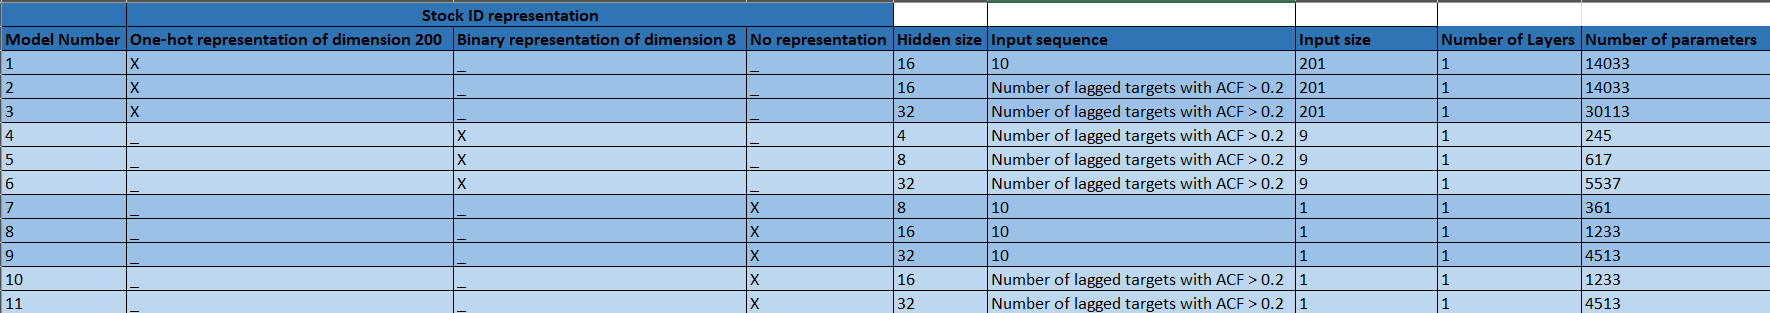
The best-performing model is the one that yields the lowest MAD with the smallest number of parameters.<br>
Based on the above metrics, the best performing model is <b>Model 4.</b>

## 9) Observations

- All models exhibit an MAD which is equal or higher than the 'mean of target' baseline. This is an indication of poor model quality. This poor performance could, potentially, be attributed to the following reasons: -<br>
  - <b>Stock ID representation: -</b>
    - One-hot encoding (dimension 200): - is high dimensional and does not capture any meaningful relationship or similarity between stock IDs.
    - 8-bit binary encoding (dimension 8): - is a relatively lower dimensional representation but still does not capture any meaningful relationship or similarity between stock IDs.
    - Excluding stock ID: - could be leading to poor model performance because of the presence of stock-specific patterns in the target.
  - <b>Non-linear relationships: -</b>The ACF and PACF are pearson correlation of coefficients and therefore only measure linear relationships between the target at the current time ID and lagged targets.<br>
  - <b>Time-varying relationships</b>: - The weights of the model that capture the relationship between the input sequences and the target value might be time-variant.
  - <b>Small number of features</b>: - This was a deliberate choice, as in this approach, the focus was on developing a model based exclusively on the relationship fo the target with the lagged targets.